# $H$ and $E$ fields from a magnetic source using the duality principle

We know that we can get the magnetic fields from the electric fields using Faraday's law, see the notebook [5a_Obtaining_the_magnetic_field](./5a_Obtaining_the_magnetic_field.ipynb).

However, what about calculating the fields generated by a magnetic source? There are two ways we can achieve that:
- using the duality principle, which is what we do in this notebook;
- creating an electric loop source, see the notebook [5c_Magnetic_source_using_el_loop](./5c_Magnetic_source_using_el_loop.ipynb).

`emg3d` solves the following equation,
$$
    \eta \mathbf{\hat{E}} - \nabla \times \zeta^{-1} \nabla \times \mathbf{\hat{E}} = -\mathbf{\hat{J}}^e_s ,
    \qquad (1)
$$

where $\eta = \sigma - \mathrm{i}\omega\varepsilon$, $\zeta = \mathrm{i}\omega\mu$, $\sigma$ is conductivity (S/m), $\omega=2\pi f$ is the angular frequency (Hz), $\mu=\mu_0\mu_\mathrm{r}$ is magnetic permeability (H/m), $\varepsilon=\varepsilon_0\varepsilon_\mathrm{r}$ is electric permittivity (F/m), $\mathbf{\hat{E}}$ the electric field in the frequency domain (V/m), and  $\mathbf{\hat{J}}^e_s$ source current.

This is the electric field due to an electric source. One can obtain the magnetic field due to a magnetic field by substituting

- $\eta \leftrightarrow -\zeta$ ,
- $\mathbf{\hat{E}} \leftrightarrow -\mathbf{\hat{H}}$ ,
- $\mathbf{\hat{J}}^e_s \leftrightarrow \mathbf{\hat{J}}^m_s$ ,

which is called the **duality principle**. 

Carrying out the substitution yields

$$
    \zeta \mathbf{\hat{H}} - \nabla \times \eta^{-1} \nabla \times \mathbf{\hat{H}} = -\mathbf{\hat{J}}^m_s ,
    \qquad  (2)
$$

which is for a magnetic dipole. Changing it for a loop source adds a term $\mathrm{i}\omega\mu$ to the source term, resulting in

$$
    \zeta \mathbf{\hat{H}} - \nabla \times \eta^{-1} \nabla \times \mathbf{\hat{H}} =
    -\mathrm{i}\omega\mu\mathbf{\hat{J}}^m_s ; \qquad  (3)
$$

see [empymod/empymod-examples/blob/master/7b_Dipoles_and_Loops.ipynb](https://github.com/empymod/empymod-examples/blob/master/7b_Dipoles_and_Loops.ipynb) for more information.

As of now, `emg3d` is not properly set-up for the duality principle, something that will hopefully change in the future. However, you do provide resistivity $\rho$ (which could be tri-axial anisotropic) and magnetic permeability $\mu_\mathrm{r}$, which is currently restricted to isotropic values. So we can abuse these parameters to implement the duality principle. As the magnetic permeability is isotropic, this will only work for isotropic resistivity models.

The actual implemented equation in `emg3d` is a slightly modified version of Equation (1), 

$$
    \mathrm{i}\omega \mu_0(\sigma - \mathrm{i}\omega\varepsilon) \mathbf{\hat{E}} - \nabla \times
    \mu_r^{-1} \nabla \times \mathbf{\hat{E}} =
    -\mathrm{i}\omega\mu_0\mathbf{\hat{J}}_s . \qquad (4)
$$

We therefore need only the following substitution to get from (4) to (3):

- $\mathrm{i}\omega\mu_0(\sigma-\mathrm{i}\omega\varepsilon) \Rightarrow \mathrm{i}\omega\mu$, and
- $\mu_\mathrm{r} \Rightarrow \sigma$ .

However, the only parameter we can supply currently is resistivity $\rho$ and relative magnetic permeability $\mu_\mathrm{r}$. By setting $\rho=1$ and $\mu_\mathrm{r} = 1/\rho$, we get:

- $\mathrm{i}\omega\mu_0(1-\mathrm{i}\omega\varepsilon) = \mathrm{i}\omega\mu_0+\omega^2\mu_0\varepsilon) \approx  \mathrm{i}\omega\mu$ (in the diffusive regime), and
- $\mu_\mathrm{r} = 1/\rho = \sigma$ .

This is what we do in this notebook, for an arbitrarily rotated loop in a homogenous, isotropic fullspace. We compare the result to the semi-analytical solution of `empymod`. (The code `empymod` is an open-source code which can model CSEM responses for a layered medium including VTI electrical anisotropy, see https://empymod.github.io.)

**Of course, implementing the duality principle properly in `emg3d` would be better.**

#### Requires
- ``emg3d``, ``discretize``, ``empymod``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as sint
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')

### Plotting and interpolation routines

In [3]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def plot_data_rel(ax, name, data, x, vmin=-15., vmax=-7., mode="log"):
    """Plot function."""
    
    ax.set_title(name)
    ax.set_xlim(min(x)/1000, max(x)/1000)
    ax.set_ylim(min(x)/1000, max(x)/1000)
    ax.axis("equal")
    
    if isinstance(mode, str):
        if mode == "abs":
            cf = ax.pcolormesh(x/1000, x/1000, np.log10(np.abs(data)), linewidth=0,
                               rasterized=True, cmap="viridis", vmin=vmin, vmax=vmax)
        else:
            cf = ax.pcolormesh(x/1000, x/1000, data, linewidth=0, rasterized=True, cmap="PuOr_r",
                               norm=SymLogNorm(linthresh=10**vmin, vmin=-10**vmax, vmax=10**vmax))
    else:
        cf = ax.pcolormesh(x/1000, x/1000, np.log10(data), vmin=vmin, vmax=vmax,
                           linewidth=0, rasterized=True, cmap=discrete_cmap(8, "RdBu_r"))

    return cf


def plot_result_rel(depm, de3d, x, title, vmin=-15., vmax=-7., mode="log"):
    fig, axs = plt.subplots(figsize=(18, 10), nrows=2, ncols=3)
    
    if mode == "log":
        case = ""
    else:
        case = "|"

    # Plot Re(data)
    cf0 = plot_data_rel(axs[0, 0], r"(a) "+case+"Re(empymod)"+case, depm.real, x, vmin, vmax, mode)
    plot_data_rel(axs[0, 1], r"(b) "+case+"Re(emg3d)"+case, de3d.real, x, vmin, vmax, mode)
    cf2 = plot_data_rel(axs[0, 2], r"(c) Error real part",
                        np.abs((depm.real-de3d.real)/depm.real)*100, x,
                        vmin=-2, vmax=2, mode=True)

    # Plot Im(data)
    plot_data_rel(axs[1, 0], r"(d) "+case+"Im(empymod)"+case, depm.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 1], r"(e) "+case+"Im(emg3d)"+case, de3d.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 2], r"(f) Error imaginary part",
                  np.abs((depm.imag-de3d.imag)/depm.imag)*100, x, vmin=-2, vmax=2, mode=True)

    # Colorbars
    fig.colorbar(cf0, ax=axs[0, :], label=r"$\log_{10}$ Amplitude (A/m)")
    cbar = fig.colorbar(cf2, ax=axs[1, :], label=r"Relative Error")
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.ax.set_yticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

    # Axis label
    fig.text(0.4, 0.05, "Inline Offset (km)", fontsize=14)
    fig.text(0.08, 0.6, "Crossline Offset (km)", rotation=90, fontsize=14)

    # Title
    fig.suptitle(title, y=1, fontsize=20)

    
def plot_lineplot_ex(x, y, data, epm_fs, grid):
    xi = x.size//2
    yi = y.size//2
    
    fn = sint.interp1d(x, data[:, xi], bounds_error=False)
    x1 = fn(grid.vectorNx)
    
    fn = sint.interp1d(y, data[yi, :], bounds_error=False)
    y1 = fn(grid.vectorNx)

    plt.figure(figsize=(15, 8))
        
    plt.plot(y/1e3, np.abs(epm_fs[yi, :]), 'C1', lw=3, label='Inline empymod')
    plt.plot(y/1e3, np.abs(data[yi, :]), 'k:', label='Inline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(y1), 'k*', label='Grid points emg3d')

    plt.yscale('log')
    plt.title(r'Inline $H_x$', fontsize=20)
    plt.xlabel('Offset (km)', fontsize=14)
    plt.ylabel(r'|Amplitude (A/m)|', fontsize=14)
    plt.legend()
    plt.show()

## Full-space model for a rotated magnetic loop 

### `empymod`

In [4]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()

# Model parameters
resh = 1.              # Horizontal resistivity
src = [0, 0, -300, 10, 70]  # Source: [x, y, z, azimuth, dip]
zrec = -400.           # Receiver depth
freq = 0.77            # Frequency
strength = np.pi       # Source strength

# Input for empymod
model = {  # empymod has positive z-down, so switch source-z and dip
    'src': [src[0], src[1], -src[2], src[3], -src[4]],
    'depth': [],
    'res': resh,
    'strength': strength,
    'freqtime': freq,
    'htarg': {'pts_per_dec': -1},
}

In [5]:
rxx = rx.ravel()
ryy = ry.ravel()

# e-field
epm_fs_ex = empymod.loop(rec=[rxx, ryy, -zrec, 0, 0], mrec=False, verb=3, **model).reshape(np.shape(rx))
epm_fs_ey = empymod.loop(rec=[rxx, ryy, -zrec, 90, 0], mrec=False, verb=1, **model).reshape(np.shape(rx))
epm_fs_ez = empymod.loop(rec=[rxx, ryy, -zrec, 0, -90], mrec=False, verb=1, **model).reshape(np.shape(rx))

# h-field
epm_fs_hx = empymod.loop(rec=[rxx, ryy, -zrec, 0, 0], verb=1, **model).reshape(np.shape(rx))
epm_fs_hy = empymod.loop(rec=[rxx, ryy, -zrec, 90, 0], verb=1, **model).reshape(np.shape(rx))
epm_fs_hz = empymod.loop(rec=[rxx, ryy, -zrec, 0, -90], verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  
   res     [Ohm.m] :  1
   aniso       [-] :  1
   epermH      [-] :  1
   epermV      [-] :  1
   mpermH      [-] :  1
   mpermV      [-] :  1

>  MODEL IS A FULLSPACE
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  0.77
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 dipole(s)
     > x       [m] :  0
     > y       [m] :  0
     > z       [m] :  300
     > azimuth [°] :  10
     > dip     [°] :  -70
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  400
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   :  14 15 16
* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:00.8285

### `emg3d`

In [6]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = emg3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx, src[2])
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,358.71      4,505.64     20.00    166.93    1.03
   y    128     -4,358.71      4,505.64     20.00    166.93    1.03
   z    128     -4,658.71      4,205.64     20.00    166.93    1.03

### Abuse the parameters to take advantage of the duality principle

See text at the top. We set here $\rho=1$ and $\mu_\mathrm{r} = 1/\rho$ to get:

- $\mathrm{i}\omega\mu_0(1-\mathrm{i}\omega\varepsilon) = \mathrm{i}\omega\mu_0+\omega^2\mu_0\varepsilon) \approx  \mathrm{i}\omega\mu$ (in the diffusive regime), and
- $\mu_\mathrm{r} = 1/\rho = \sigma$ .

In [7]:
# Get the model        => Set res_x = 1 and mu_r = 1./resh
pmodel = emg3d.utils.Model(pgrid, res_x=1., freq=freq, mu_r=1./resh)

In [8]:
# Get the source field
sfield = emg3d.utils.get_source_field(pgrid, src, freq, strength)

# Calculate the electric field
hfield = emg3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 19:26:50 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [19:27:02]   2.307e-02  after   1 F-cycles   [3.116e-07, 0.023]   0 0
   [19:27:13]   2.095e-03  after   2 F-cycles   [2.830e-08, 0.091]   0 0
   [19:27:24]   2.128e-04  after   3 F-cycle

## Compare the magnetic field generated from the magnetic source

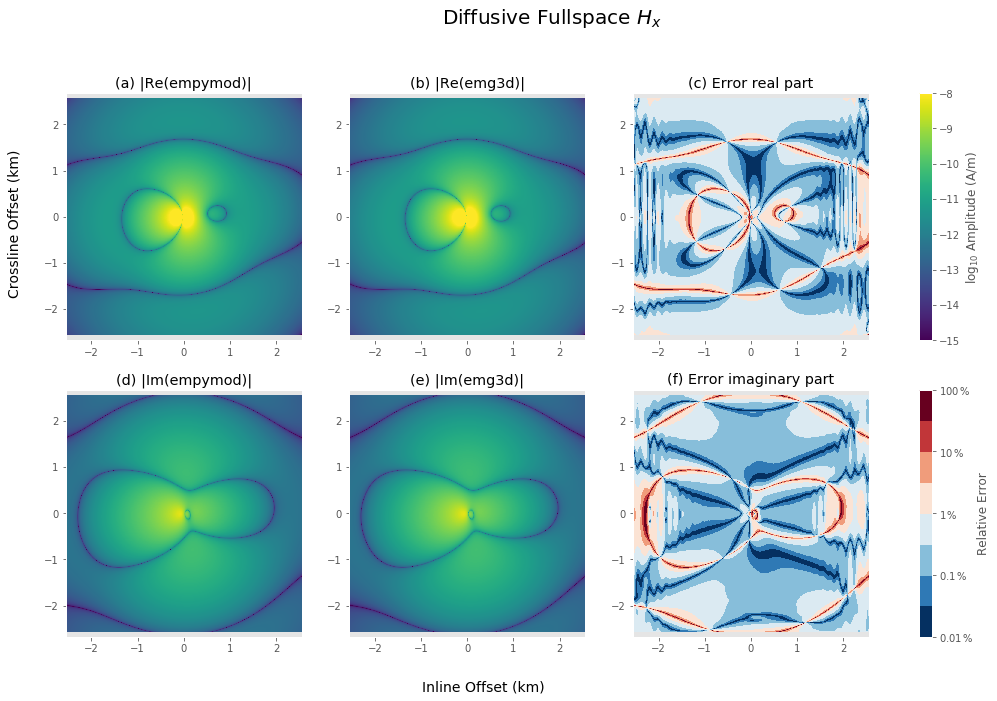

In [9]:
e3d_fs_hx = emg3d.utils.get_receiver(pgrid, hfield.fx, (rx, ry, zrec))
plot_result_rel(epm_fs_hx, e3d_fs_hx, x, r'Diffusive Fullspace $H_x$', vmin=-15, vmax=-8, mode='abs')

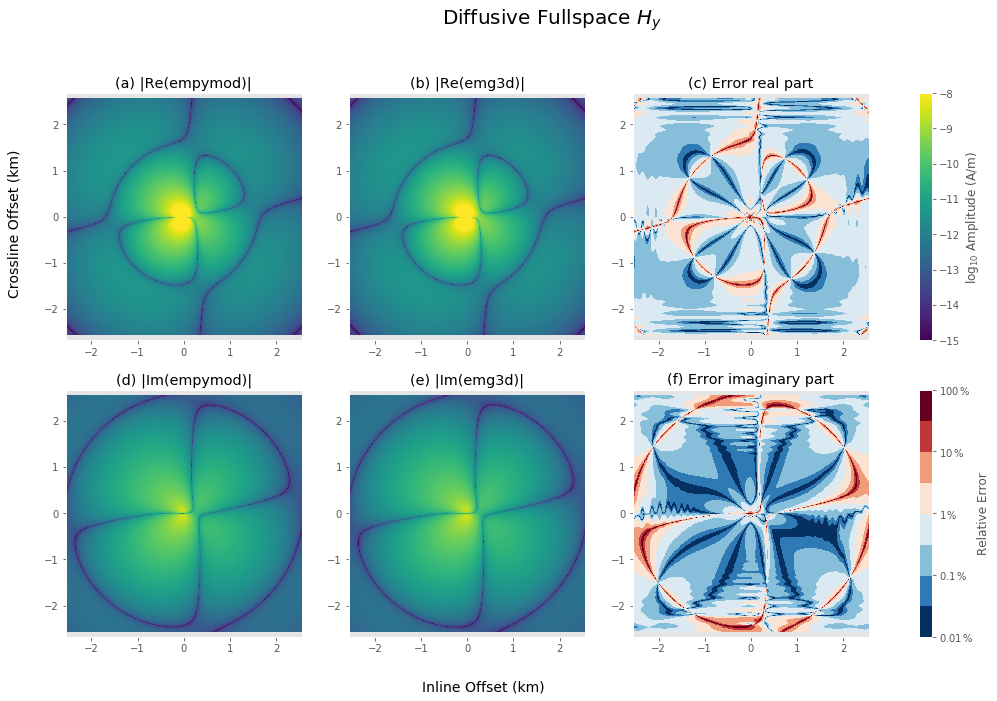

In [10]:
e3d_fs_hy = emg3d.utils.get_receiver(pgrid, hfield.fy, (rx, ry, zrec))
plot_result_rel(epm_fs_hy, e3d_fs_hy, x, r'Diffusive Fullspace $H_y$', vmin=-15, vmax=-8, mode='abs')

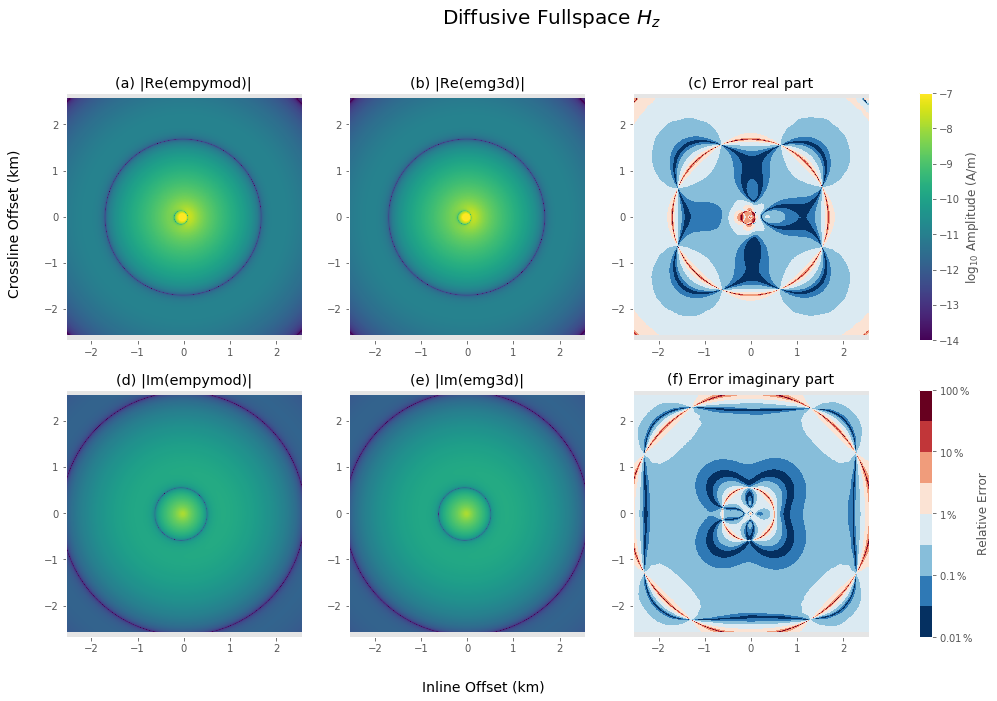

In [11]:
e3d_fs_hz = emg3d.utils.get_receiver(pgrid, hfield.fz, (rx, ry, zrec))
plot_result_rel(epm_fs_hz, e3d_fs_hz, x, r'Diffusive Fullspace $H_z$', vmin=-14, vmax=-7, mode='abs')

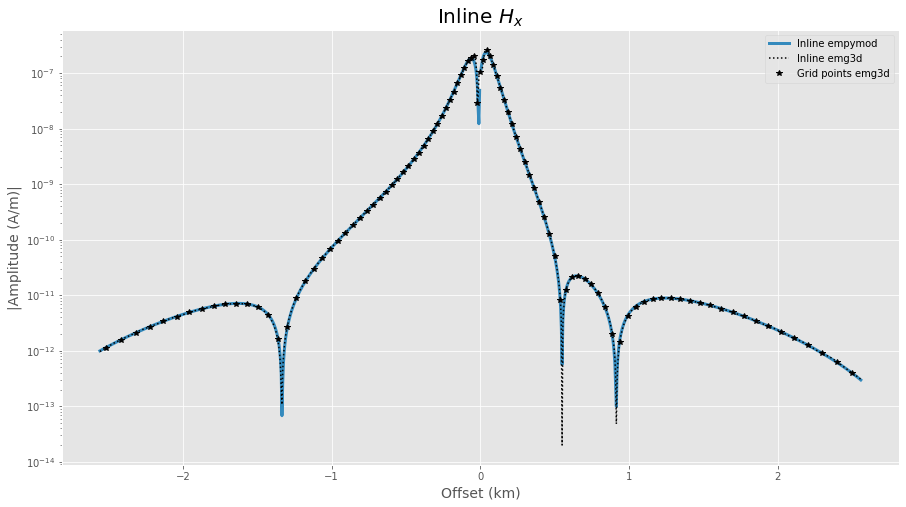

In [12]:
plot_lineplot_ex(x, x, e3d_fs_hx.real, epm_fs_hx.real, pgrid)

## Compare the electric field generated from the magnetic source

`get_h_field` gets the $H$-field from the $E$-field with Faraday's law, 

$$
\nabla \times \mathbf{E} = \rm{i}\omega \mathbf{B} = \rm{i}\omega\mu\mathbf{H}\, .
$$

Using the substitutions introduced in the beginning, and using the same function but to get the $E$-field from the $H$-field, we have to multiply the result by
$$
-\rm{i}\omega\mu\, .
$$


### Calculate electric field $E$ from the magnetic field

In [13]:
efield = -emg3d.utils.get_h_field(pgrid, pmodel, hfield)*2j*np.pi*freq*4e-7*np.pi

### Plot

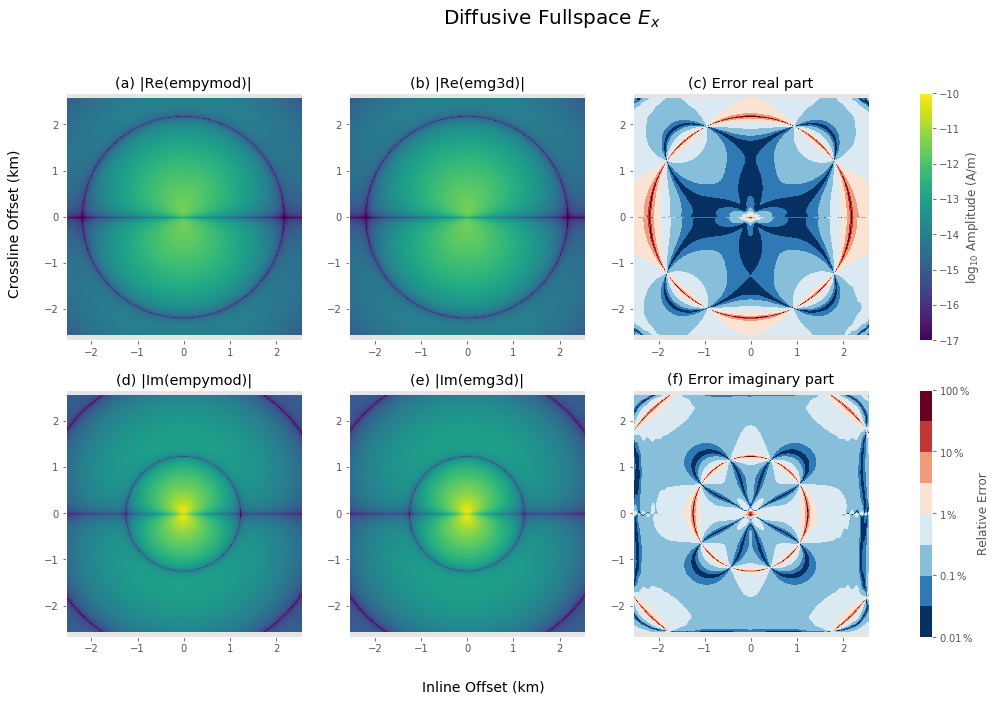

In [14]:
e3d_fs_ex = emg3d.utils.get_receiver(pgrid, efield.fx, (rx, ry, zrec))
plot_result_rel(epm_fs_ex, e3d_fs_ex, x, r'Diffusive Fullspace $E_x$', vmin=-17, vmax=-10, mode='abs')

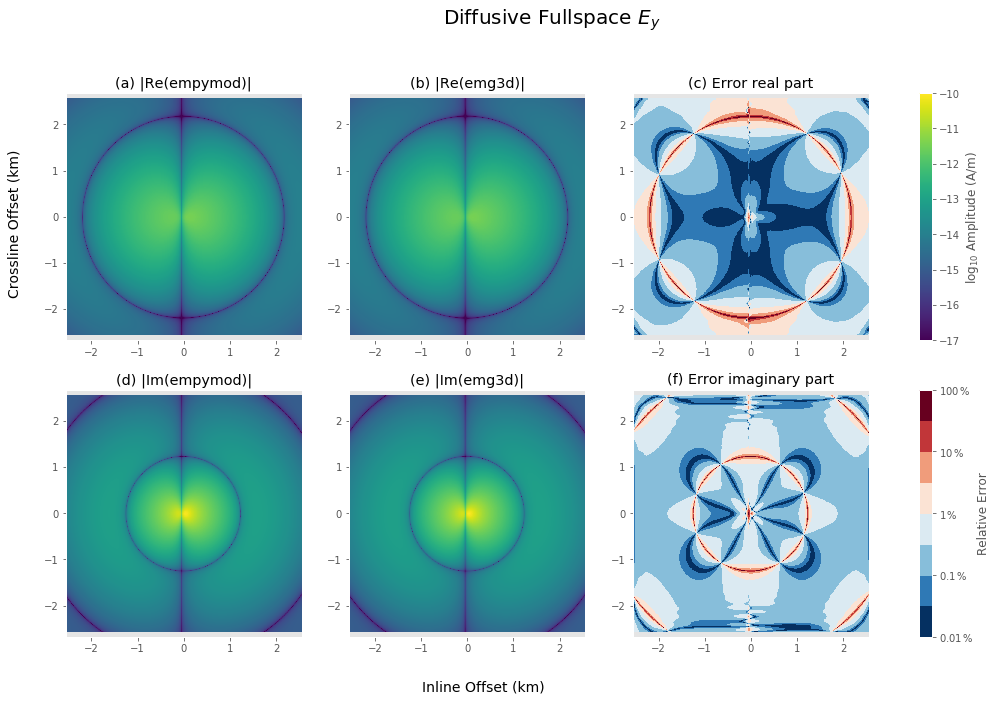

In [15]:
e3d_fs_ey = emg3d.utils.get_receiver(pgrid, efield.fy, (rx, ry, zrec))
plot_result_rel(epm_fs_ey, e3d_fs_ey, x, r'Diffusive Fullspace $E_y$', vmin=-17, vmax=-10, mode='abs')

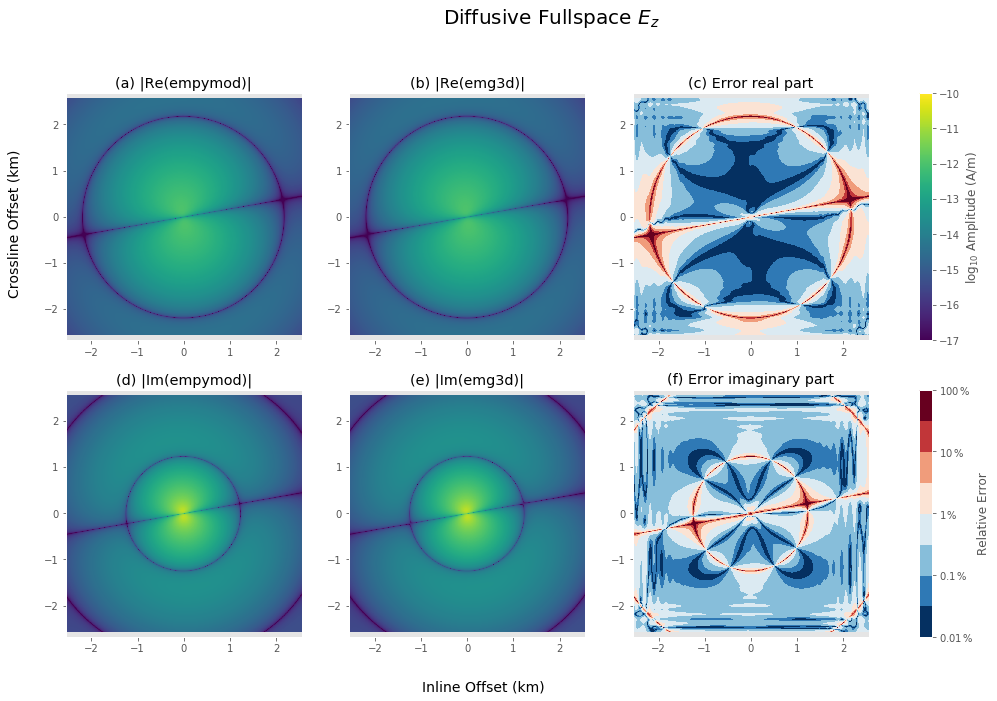

In [16]:
e3d_fs_ez = emg3d.utils.get_receiver(pgrid, efield.fz, (rx, ry, zrec))
plot_result_rel(epm_fs_ez, e3d_fs_ez, x, r'Diffusive Fullspace $E_z$', vmin=-17, vmax=-10, mode='abs')

In [17]:
emg3d.Report(empymod)

--------------------------------------------------------------------------------
  Date: Thu Oct 24 19:28:45 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.10.1 : empymod
            1.17.2 : numpy
             1.3.1 : scipy
            0.45.1 : numba
             0.8.1 : emg3d
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------